<a href="https://colab.research.google.com/github/anastasiawinter/bookanalysis/blob/main/Computer_vision_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Работа с видео и разбиение его на кадры**

## **Шаг 1:** импортируем необходимые нам библиотеки, скачиваем данные и создаём нужные нам директории (не забудьте изменить Runtime на GPU)

In [ ]:
import cv2
from tqdm import tqdm
import numpy as np
import re
import pandas as pd
from copy import copy
from PIL import Image
import collections
import matplotlib.pyplot as plt

'''Код визуализации, на которой можно отобразить изображения при наведении мышки на точку.'''
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource, figure, output_file, show
output_notebook()

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
os.mkdir("./frames")

In [ ]:
! gdown --id 1UYaJmJ7gvHj5H_60S0BUvR_gh12fnl24

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UYaJmJ7gvHj5H_60S0BUvR_gh12fnl24
To: /content/LaLaLand_trailer.mp4
100% 39.4M/39.4M [00:00<00:00, 120MB/s]


## **Шаг 2:** Итак, в нашей папке лежит трейлер к фильму "La-La-Land". Чтобы поработать с ним, нам надо для начала разбить его на кадры.

In [ ]:
def extract_every_k_second_frame(path_to_video, path_to_folder_2_save_frames, k: int, start_frame_index=0, 
                                 num_frames_per_sec=24):
    '''Функция отвечает за вычленение первого кадра каждой n-ной секунды (кадров т.о. становится меньше, 
    k - это номер секунды).'''
    
    vidcap = cv2.VideoCapture(path_to_video)
    success,image = vidcap.read()
    count = start_frame_index * num_frames_per_sec * k
    while success:
        success,image = vidcap.read()
        if count % (num_frames_per_sec * k) == 0:
            cv2.imwrite(path_to_folder_2_save_frames + "/{:03d}_frame.jpg".format(count // (num_frames_per_sec * k)), image)
        count += 1
    print('done')

### **Задание:** используя данную функцию, вычлените из мультфильма каждый 72 кадр трейлера. Сохраните кадры в папке "frames".

In [ ]:
"""Напишите ваш код здесь"""


#### **Решение**:

In [ ]:
film_path = 'LaLaLand_trailer.mp4'
extract_every_k_second_frame(film_path,'./frames', 3)

done


# **Работа с цветом**

## **Шаг 3:** Теперь давайте посмотри на кадры, которые мы вытащили. Например, посмотрим кадр №5.

(1136, 2558, 3)


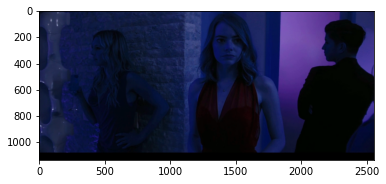

In [ ]:
image = cv2.imread("./frames/005_frame.jpg")
plt.imshow(image)
print(image.shape)

### **Вопрос**: за что отвечает число 3 в выдаче impage.shape?

 #### **Ответ**: оно обозначает, что каждый пиксель репрезентируется как комбинация 3 цветов - красного, зелёного и синего

### **Вопрос**: Какая-то Эмма Стоун синюшная, так не пойдёт. Как вы думаете, почему так произошло и что надо сделать, чтобы они стали нормального цвета?

#### **Ответ**: Это случилось, потому что по дефолту CV2 считывает показатели красного, зелёного и синего для каждого пикселя не в порядке RGB.

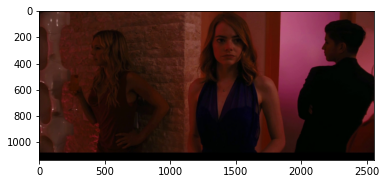

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
(r, g, b) = image[170, 300]
print("Pixel at (170, 300) - Red: {}, Green: {}, Blue: {}".format(r, g, b))

Pixel at (170, 300) - Red: 78, Green: 30, Blue: 20


## **Шаг 4:** Итак, мы выяснили, как сделать так, чтобы наши картинки выглядили нормально. Ну хорошо, предположим, что мы хотим выяснить основные цвета на нашей картинке. Здесь нам понадобится метод KMeans, про который мы говорили в прошлый раз. Допустим, мы хотим узнать 5 основных цветов на картинке.

In [ ]:
class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=5):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self, if_return_color_weights=False):
        '''Эта функция выдает параметры R, G, B для самых превалирующих на картинке цветов'''
    
        #read image
        
        img = cv2.imread(self.IMAGE)
        #convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        if if_return_color_weights:
            numLabels = np.arange(0, self.CLUSTERS+1)
            (hist, _) = np.histogram(self.LABELS, bins = numLabels)
            hist = hist.astype("float")
            hist /= hist.sum()
            return self.COLORS.astype(int), hist
        else:
            return self.COLORS.astype(int)

    
    def plotHistogram(self): 
        '''Эта функция строит гистограмму с превалирующими цветами в картинке'''
        
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

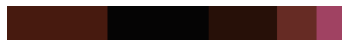

In [ ]:
img_path = "./frames/005_frame.jpg"
clusters = 5
dc1 = DominantColors(img_path, clusters)
colors, weights = dc1.dominantColors(if_return_color_weights=True) #мы хотим выяснить "вес" каждого цвета. colors - значения превалирующих цветов, weights - вес каждого цвета (в сумме - 1)
dc1.plotHistogram()

In [ ]:
colors.T @ weights #это средний цвет для картинки

array([54.34717064, 21.79947954, 18.41395195])

### **Задание**: опираясь на ранее написанный код, дописать функцию так, чтобы она доставала картинку из нашей папки "frames", выясняла её "средний" цвет, и сохраняла эти данные

#### **Написание функции с нуля:**

In [ ]:
'''вставьте 8 строк кода'''

def make_weighted_color_image_description_array(path, clusters=5):
  '
  '
  '
  '
  '
  '
  '
  '
  return np.vstack(data), src

#### **Написание функции с некоторыми подсказками:**

In [ ]:
'''вставьте 3 строки'''
def make_weighted_color_image_description_array(path, clusters=5):
    data = []
    src = []
    for file in tqdm(os.listdir(path)):
        if file.endswith('.jpg'):
            src.append(os.path.join(path, file))
            '
            '
            '
    return np.vstack(data), src

#### **Решение**:

In [ ]:
def make_weighted_color_image_description_array(path, clusters=5):
    data = []
    src = []
    for file in tqdm(os.listdir(path)):
        if file.endswith('.jpg'):
            src.append(os.path.join(path, file))
            dc = DominantColors(os.path.join(path, file), clusters)
            colors, weights = dc.dominantColors(if_return_color_weights=True)
            data.append(colors.T @ weights)
    return np.vstack(data), src

## **Шаг 5**: время получить наши данные про каждую картинку. Данные - путь к картинке и средний цвет для каждой из них, состоящий из трёх показателей - R, G и B (*пропустить*)

In [ ]:
path = "./frames"
data, src = make_weighted_color_image_description_array(path, clusters=5)

In [ ]:
"""Я сохранила эти данные, потому что их долго надо было качать. Вы их можете скачать с гугл-диска"""
np.savetxt("data.csv", data, delimiter=",")
with open("src.txt", "w") as file:
  for line in src:
    file.write(str(line) + "\n")
  file.close()

## **Шаг 6**: откроем наши данные

In [ ]:
! gdown --id 1L7FBGF7kUgbYTslTwgvW0w2X9ACR938y
! gdown --id 1lpDXZndGkMS_a4gLb-zYt-XzE-1OKHVi

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1L7FBGF7kUgbYTslTwgvW0w2X9ACR938y
To: /content/src.txt
100% 1.63k/1.63k [00:00<00:00, 2.77MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lpDXZndGkMS_a4gLb-zYt-XzE-1OKHVi
To: /content/data.csv
100% 5.33k/5.33k [00:00<00:00, 8.05MB/s]


### **Задание**: выясните, как открыть .csv и получить из него numpy.array. Кроме того, откройте .txt и сохраните его как список. Свои переменные назовите my_data и my_src соответственно.

In [ ]:
"""Напишите ваш код здесь"""


#### **Решение**:

In [ ]:
df = pd.read_csv('data.csv', sep=',', header=None)
my_data = df.values

with open("src.txt") as file:
  my_src = file.readlines()
  file.close()

my_src = [line.strip("\n") for line in my_src]

## **Шаг 7**: уменьшим размерность наших данных с помощью PCA и визуализируем цветовое распределение на графике.

In [ ]:
'''Поскольку мы хотим изобразить это на 2-мерном графике, а данные у нас трёхмерные, нам надо уменьшить размерность. Для этого мы используем PCA.'''
pca_mean_colors = PCA(2).fit_transform(my_data)
pca_mean_colors[:, 1] = - pca_mean_colors[:, 1] 

In [ ]:
def visualize_color_distribution(pca_mean_colors_film_list, src_list, each_n_frame=1,
                                       colors=['#ff0000', 
                                               '#0000ff',
                                               'royalblue',
                                               'black',
                                               'pink',
                                               'sandybrown']):
    
    sources = [
        ColumnDataSource(data=dict(
            x= pca_mean_colors[:,0][::each_n_frame], #берем у всех картинок первый показатель pca из двух
            y= pca_mean_colors[:, 1][::each_n_frame],#берем у всех картинок второй показатель pca из двух
            desc=list(range(len(relative_source)))[::each_n_frame],#это описание картинки на графике
            imgs= relative_source[::each_n_frame],#это путь к картинке
            fonts = ['<i>trailer</i>'] * len(relative_source[::each_n_frame]))
        )
        for pca_mean_colors, relative_source in zip(pca_mean_colors_film_list, src_list)]



    TOOLTIPS = """
        <div>
            <div>
                <img
                    src="@imgs" height="187" alt="@imgs" width=333""
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966; alpha: 0.25">[$index]</span>
            </div>
            <div>
                <span>@fonts{safe}</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;  alpha: 0.25">($x, $y)</span>
            </div>
        </div>
    """

    p = figure(plot_width=1000, plot_height=500, tooltips=TOOLTIPS,
               title="Распределение цвета в 'La-La-Land'")

    # p.circle('x', 'y', size=15, alpha=0.25, color='#62b696', source=source_2012)
    for source, color in zip(sources, colors):
        p.circle('x', 'y', size=15, alpha=0.25, color=color, source=source)

    show(p)

### **ВАЖНО: сейчас на этом графике не отобразятся картинки. Почему - для меня загадка, поскольку абсолютно идентичный код в Jupyter работает прекрасно.**

In [ ]:
visualize_color_distribution([pca_mean_colors], [my_src])

# **Работа с длиной кадра**

## **Шаг 3**: импортируем дополнительные библиотеки

In [ ]:
from scenedetect import VideoManager
from scenedetect import SceneManager
from scenedetect.detectors import ContentDetector

### **Задание**: Colab не знает библиотеки scenedetect. Скачайте её.

In [ ]:
"""Напишите ваш код здесь"""

#### **Решение**:

In [ ]:
! pip install scenedetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 9.2 MB/s eta 0:00:00


## **Шаг 4**: Создадим необходимые нам функции для работы с видео

In [ ]:
'''выдает таплы с тем, на каком кадре начинается и на каком заканчивается сцена'''
def find_scenes(video_path, threshold=25.0):
    # Create our video & scene managers, then add the detector.
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=threshold))

    # Improve processing speed by downscaling before processing.
    video_manager.set_downscale_factor()

    # Start the video manager and perform the scene detection.
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)

    # Each returned scene is a tuple of the (start, end) timecode.
    return scene_manager.get_scene_list()

### **Задание**: допишите функцию так, чтобы она умела преобразовывать время вида 00:04:59.174 в количество секунд

In [ ]:
def time_2_num_sec(time, num_round_digits=1): 
    sec = ''''''''''''
    return round(sec, num_round_digits)

#### **Решение**:

In [ ]:
'''конвертирует время из часов и минут чисто в секунды'''
def time_2_num_sec(time, num_round_digits=1): 
    sec = int(time[:2]) * 3600 + int(time[3:5]) * 60 + float(time[6:])
    return round(sec, num_round_digits)

## **Шаг 5**: Вычленим сцены и визуализируем их 

In [ ]:
def film_shots_lengths_preprocessing(path):
    
    scenes = find_scenes(path) #находим сцены в фильме
    
    shot_start_times = [str(scene[0])[:-4] for scene in scenes] #вычленяем начало сцен
    
    full_shot_length = [str(end - start) for start, end in scenes] #вычленяем длину сцен
    
    shot_lengths = list(map(time_2_num_sec, full_shot_length)) #длину сцен конвертируем в секунды
    
    return shot_lengths, shot_start_times

In [ ]:
def plot_scene_lengths(title, color, shot_lengths, shot_start_times, each_shot = 1, step=2, if_draw_line=True):

    plt.style.use('ggplot')
    plt.figure(figsize=(50,25))
    plt.bar(shot_start_times,shot_lengths, color=color)
    plt.xticks(shot_start_times[::each_shot], rotation = 45, fontsize=24)
    plt.yticks(range(0, int(max(shot_lengths) + step),step), fontsize=24)
    plt.xlabel('Начало сцены', fontsize=28)
    plt.ylabel('Длина сцены в секундах', fontsize=28)
    plt.title(title, fontsize = 36)
    # if if_draw_line:
    #     x = range(len(shot_start_times))
    #     m, b = np.polyfit(x, shot_lengths, 1)
    #     plt.plot(x, m*np.array(x) + b, linewidth=4)
    plt.show()

### **Задание**: пользуясь вышеописанными функциями, вычлените длину сцен и начало сцен. Визуализируйте полученные данные.

In [ ]:
"""Напишите ваш код здесь"""

#### **Решение**:

In [ ]:
shot_lengths, shot_start_times = film_shots_lengths_preprocessing('/content/LaLaLand_trailer.mp4')

ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 60.000 FPS, resolution: 2558 x 1136
INFO:pyscenedetect:Downscale factor set to 9, effective resolution: 284 x 126
INFO:pyscenedetect:Detecting scenes...


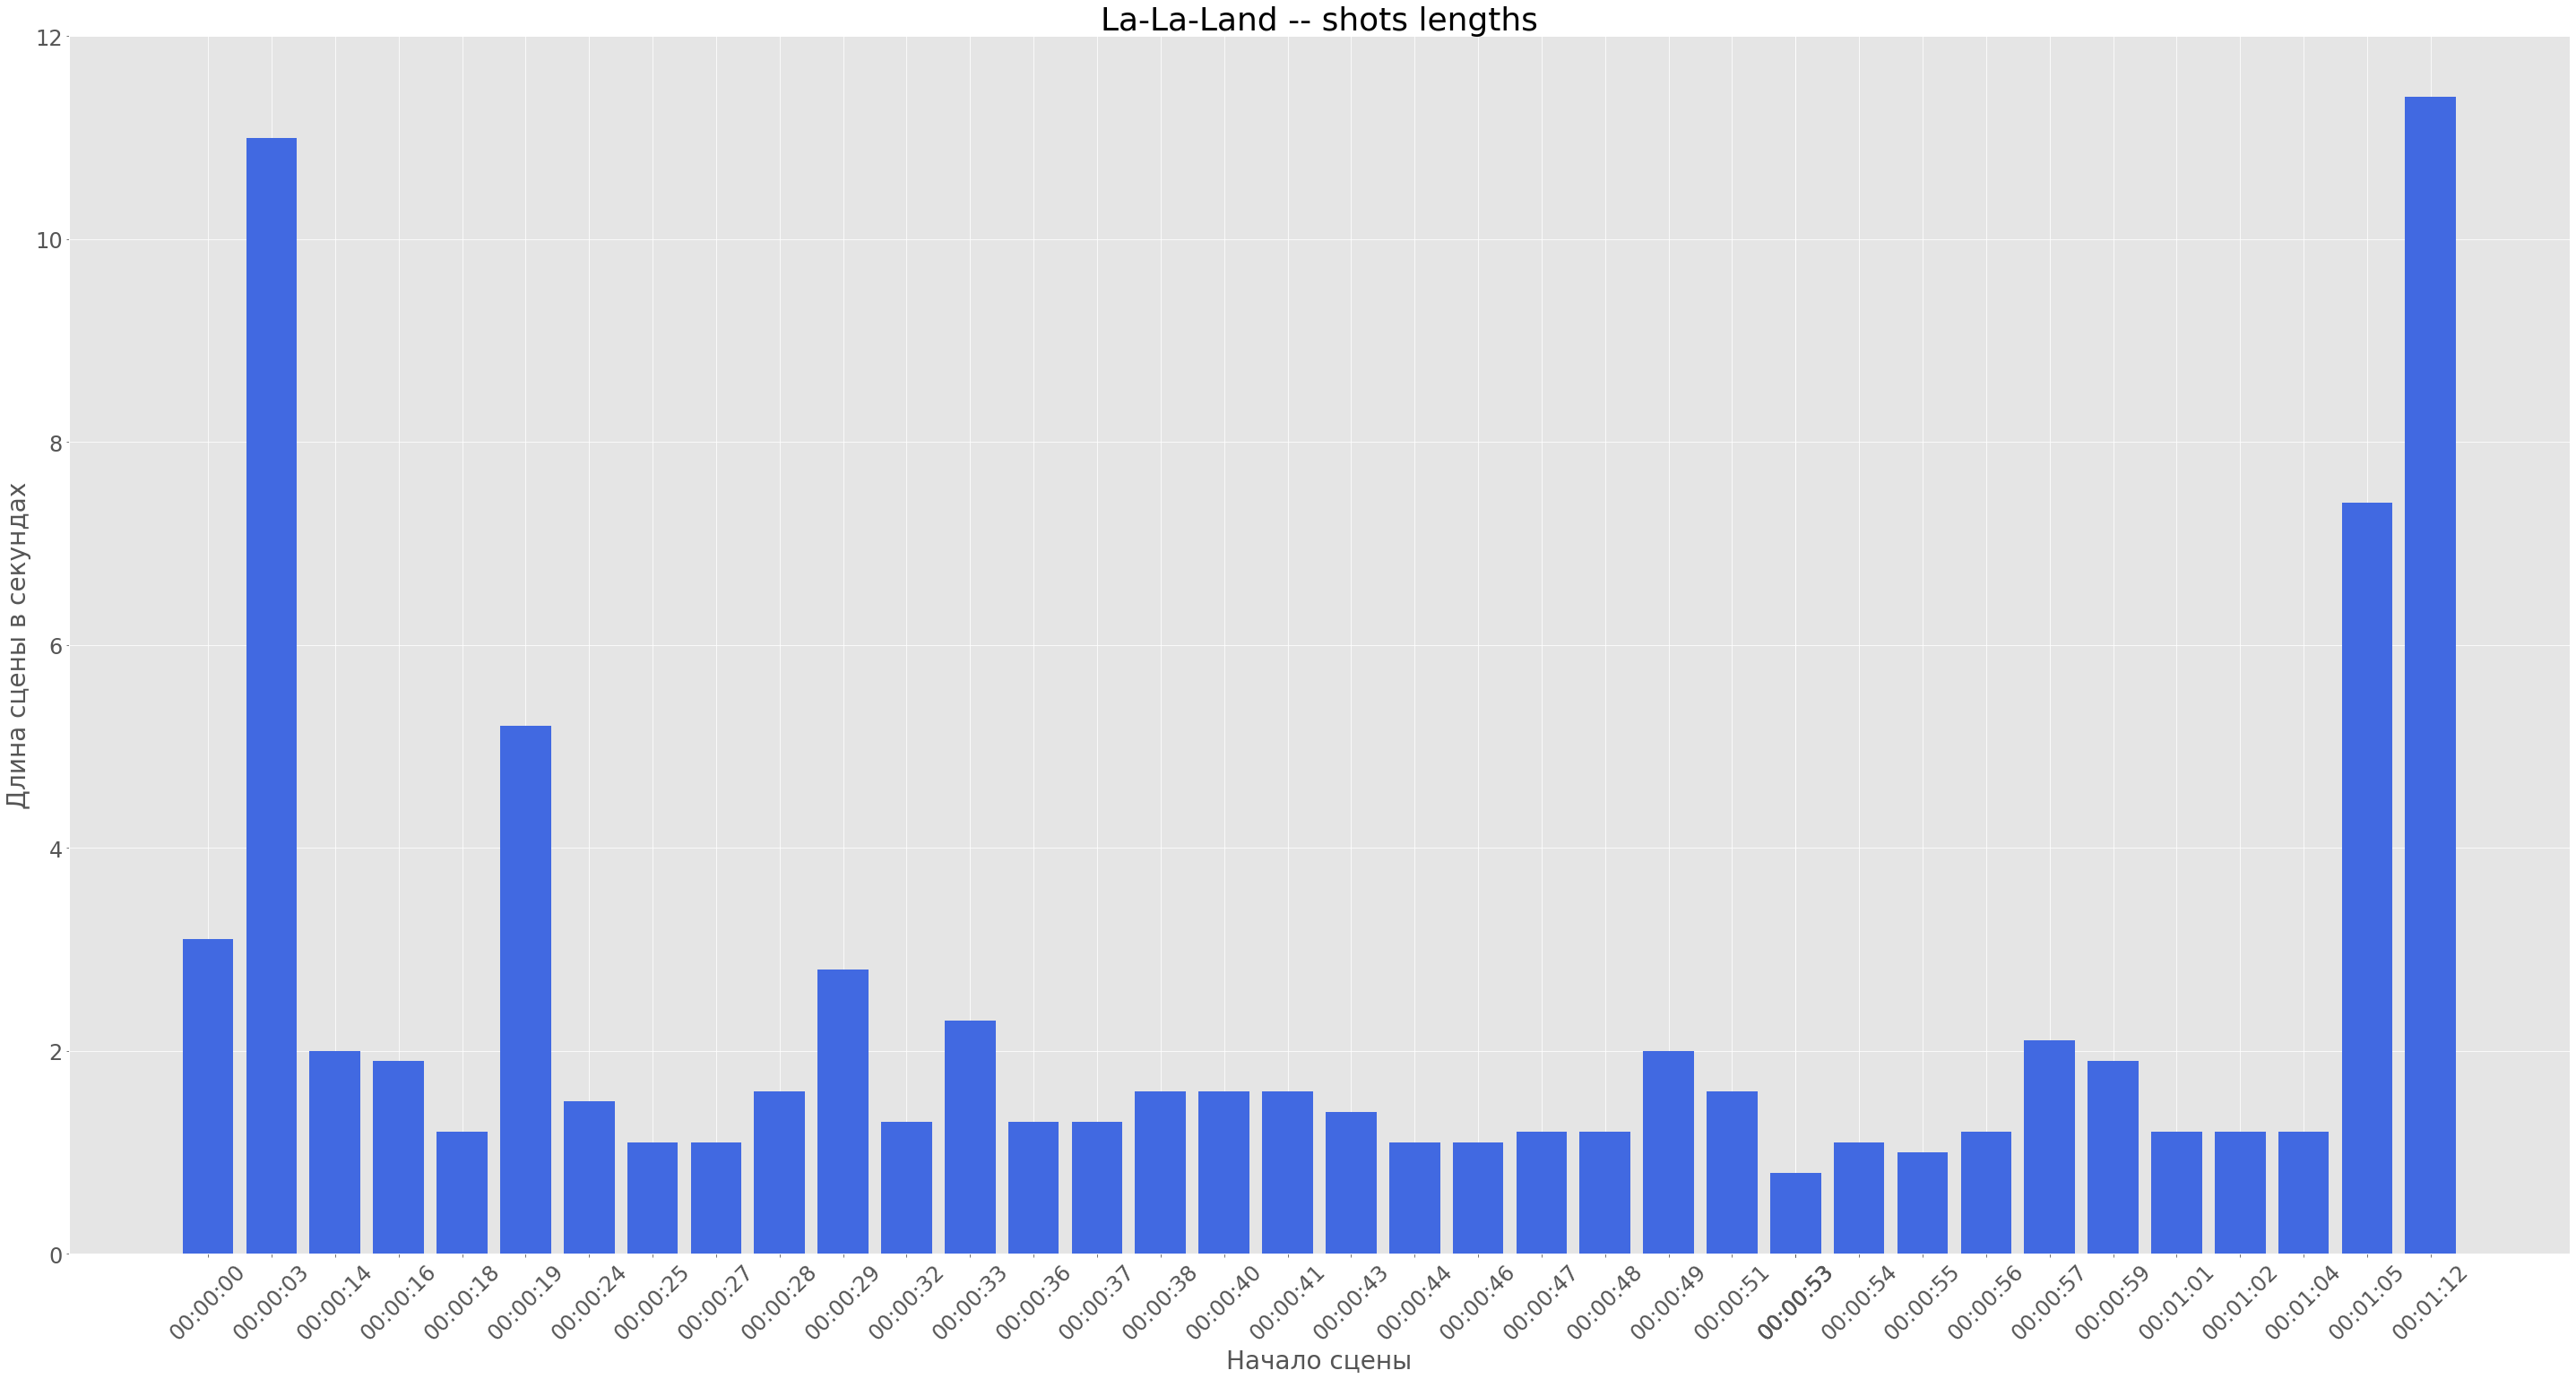

In [ ]:
plot_scene_lengths('La-La-Land -- shots lengths','royalblue', shot_lengths, shot_start_times)

# **Работа с лицами**

## **Шаг 3**: импортируем дополнительные библиотеки (не забудьте изменить Runtime на GPU)

In [ ]:
! pip install face-recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=38c18d5a879c2bc1c152d6b3adebe063779870ea67bc2aba1a697185ce5f35d9
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models


In [ ]:
import face_recognition

## **Шаг 4**: создаём функцию, которая умеет находить лица, считать их количество на картинке и рассчитывать их процент

In [ ]:
def compute_face_areas_with_percents_face_recognition(directory, small_face_percent_treshold=1.):
    
    columns_name = ['frame_num', 'num_of_faces', 'face_percentage', 'face_coordinates']
    data = pd.DataFrame(columns = columns_name)

    for file in tqdm(os.listdir(directory)):
        if file.endswith('.jpg'):
            image = face_recognition.load_image_file(os.path.join(directory, file))
            full_img_size = image.shape[0]*image.shape[1]
            all_face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=2)
            
            big_face_percentages = []
            big_face_locations = []
            for face_location in all_face_locations:
                top, right, bottom, left = face_location
                face_square = (bottom-top)*(right-left)
                percentage_of_face_in_img = (face_square/full_img_size)*100
                if percentage_of_face_in_img > small_face_percent_treshold:
                    big_face_percentages.append(round(percentage_of_face_in_img, 1))
                    big_face_locations.append(face_location)
                    
            dict_of_frames = {'frame_num': file, 'num_of_faces':len(big_face_locations), 
                              'face_percentage': big_face_percentages, 
                                  'face_coordinates': big_face_locations}

            data = data.append(dict_of_frames, ignore_index=True)
    return data

## **Шаг 5**: посчитаем количество лиц на кадрах, их процент и расположение (*пропустить*)

In [ ]:
df_LLL = compute_face_areas_with_percents_face_recognition("./frames")

In [ ]:
df_LLL["width"] = 1136
df_LLL["height"] = 2558
df_LLL.head()

In [ ]:
"""Я сохраню наши данные, чтобы мы могли их подгрузить на паре"""
df_LLL.to_csv("df_LLL.csv")

## **Шаг 6**: откроем наши данные и посмотрим на то, как они выглядят

In [ ]:
! gdown --id 1ydz-gslYzphVfIeCjQ_sE4jwR23K67oS

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ydz-gslYzphVfIeCjQ_sE4jwR23K67oS
To: /content/df_LLL.csv
100% 3.14k/3.14k [00:00<00:00, 6.80MB/s]


### **Задание**: откройте csv документ и посмотрите первые 5 строк

In [ ]:
""""Напишите ваш код здесь"""

#### **Решение**:

In [ ]:
df_LLL = pd.read_csv("df_LLL.csv", sep=',', index_col=0)

In [ ]:
df_LLL.head()

,frame_num,num_of_faces,face_percentage,face_coordinates,width,height
0,000_frame.jpg,0,[],[],1136,2558
1,024_frame.jpg,1,[7.9],"[(255, 2064, 734, 1585)]",1136,2558
2,060_frame.jpg,1,[16.4],"[(214, 1747, 904, 1057)]",1136,2558
3,026_frame.jpg,0,[],[],1136,2558
4,062_frame.jpg,0,[],[],1136,2558


## **Шаг 7**: на всякий случай, создадим копию нашего датафрейма, с которой будем работать. Если что-то пойдет не так, мы всегда сможем вернуться к исходнику, не загружая его снова, а оперируя переменной, в которой он лежит

In [ ]:
df_LLL_copy = df_LLL.copy()

In [ ]:
one_face = df_LLL_copy.loc[df_LLL_copy['num_of_faces'] == 1]
one_face

,frame_num,num_of_faces,face_percentage,face_coordinates,width,height
1,024_frame.jpg,1,[7.9],"[(255, 2064, 734, 1585)]",1136,2558
2,060_frame.jpg,1,[16.4],"[(214, 1747, 904, 1057)]",1136,2558
5,030_frame.jpg,1,[1.3],"[(144, 1834, 337, 1641)]",1136,2558
22,029_frame.jpg,1,[1.3],"[(144, 1877, 337, 1684)]",1136,2558
23,003_frame.jpg,1,[2.7],"[(239, 1687, 517, 1409)]",1136,2558
35,004_frame.jpg,1,[2.6],"[(178, 1625, 455, 1348)]",1136,2558
37,048_frame.jpg,1,[23.6],"[(165, 1545, 993, 717)]",1136,2558
38,054_frame.jpg,1,[1.3],"[(187, 1770, 380, 1577)]",1136,2558
41,005_frame.jpg,1,[2.6],"[(147, 1594, 424, 1317)]",1136,2558
43,023_frame.jpg,1,[5.5],"[(256, 1099, 656, 699)]",1136,2558


In [ ]:
one_face["num_of_faces"] = pd.to_numeric(one_face["num_of_faces"])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_face["num_of_faces"] = pd.to_numeric(one_face["num_of_faces"])



In [ ]:
for index, row in one_face.iterrows():
  coordinates = row[3].strip("[]()").split(", ")
  coordinates = [int(element) for element in coordinates]
  one_face.at[index,'face_coordinates'] = coordinates

### **Задание**: сейчас тип данных в колонке 'face_percentage' - не тот, что нам нужен. Выясните, какой это тип данных, превратите элемент каждой строки колонки face_percentage в список, и создайте список one_face_percentages с процентами, которое лицо занимает от кадра

#### **Написание кода с нуля**

In [ ]:
"""Напишите ваш код здесь"""

#### **Код с некоторыми подсказками**

In [ ]:
one_face_percentages = []
for perc in one_face['face_percentage']:
  '''''''''''''
  if len(perc) == 0:
    ''''''''''''''''''
  else:
    for element in perc:
      ''''''''''''''''''''

#### **Решение**:

In [ ]:
for perc in one_face['face_percentage']:
  print(type(perc))
  print(perc.strip("[]").split())
  print(type(perc.strip("[]").split()))

<class 'str'>
['7.9']
<class 'list'>
<class 'str'>
['16.4']
<class 'list'>
<class 'str'>
['1.3']
<class 'list'>
<class 'str'>
['1.3']
<class 'list'>
<class 'str'>
['2.7']
<class 'list'>
<class 'str'>
['2.6']
<class 'list'>
<class 'str'>
['23.6']
<class 'list'>
<class 'str'>
['1.3']
<class 'list'>
<class 'str'>
['2.6']
<class 'list'>
<class 'str'>
['5.5']
<class 'list'>
<class 'str'>
['3.8']
<class 'list'>
<class 'str'>
['3.8']
<class 'list'>
<class 'str'>
['1.8']
<class 'list'>
<class 'str'>
['16.4']
<class 'list'>
<class 'str'>
['7.9']
<class 'list'>
<class 'str'>
['23.1']
<class 'list'>
<class 'str'>
['2.6']
<class 'list'>
<class 'str'>
['23.1']
<class 'list'>


In [ ]:
one_face_percentages = []
for perc in one_face['face_percentage']:
  perc = perc.strip("[]").split()
  if len(perc) == 0:
    one_face_percentages.append(0) 
  else:
    for element in perc:
      one_face_percentages.append(float(element))

### **Задание**: постройте гистрограмму, которая бы изображала процент, который занимает лицо, и количество кадров с таким процентом

#### **Написание кода с нуля**

In [ ]:
"""Напишите ваш код здесь"""

#### **Написание кода с некоторыми подсказками**

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.hist('''''''''''''')
plt.title('''''''''''''''''')
plt.xticks(range(0,int(max(one_face_percentages)),2))
plt.xlabel('''''''''''')
plt.ylabel('''''''''''''')
plt.tight_layout()

#### **Решение**:

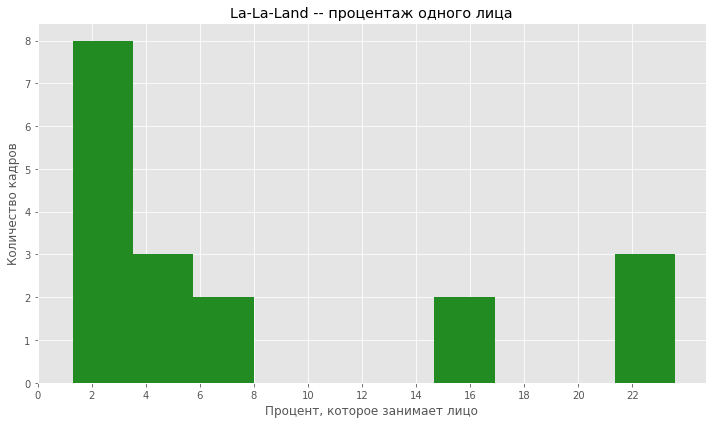

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.hist(one_face_percentages, color="forestgreen")
plt.title("La-La-Land -- процентаж одного лица")
plt.xticks(range(0,int(max(one_face_percentages)),2))
plt.xlabel('Процент, которое занимает лицо', fontsize=12)
plt.ylabel('Количество кадров', fontsize=12)
plt.tight_layout()

### **Задание**: выясните, есть ли кадры с 0/3/4 лицами в датафрейме, и если да, то сколько их

In [ ]:
"""Напишите ваш код здесь"""

#### **Решение**: 

In [ ]:
print("В датафрейме кадров без распознанного лица: ", len(df_LLL_copy.loc[df_LLL_copy['num_of_faces'] == 0]))
print("В датафрейме кадров с тремя распознанными лицами: ", len(df_LLL_copy.loc[df_LLL_copy['num_of_faces'] == 3]))
print("В датафрейме кадров с четырьмя распознанными лицами: ", len(df_LLL_copy.loc[df_LLL_copy['num_of_faces'] == 4]))

В датафрейме кадров без распознанного лица:  52
В датафрейме кадров с тремя распознанными лицами:  0
В датафрейме кадров с четырьмя распознанными лицами:  1


## **Шаг 8**: Посмотрим на распределение кадров с одним лицом в трейлере и на процентаж, который лицо занимает

In [ ]:
def creating_dict_with_shot_num_and_face_percentage(one_face_df):
    percentage_per_n_frame= {}
    for index, row in one_face_df.iterrows():
        percentage_per_n_frame[int(row[0][1:3])]= float(row[2].strip("[]"))
            
    sorted_dict_with_shot_num_and_face_percentage = collections.OrderedDict(sorted(percentage_per_n_frame.items()))
    return sorted_dict_with_shot_num_and_face_percentage

In [ ]:
dict_frame_num_perc = creating_dict_with_shot_num_and_face_percentage(one_face)

In [ ]:
def visualize_hist_of_one_face_frames(dictionary, color, num_of_frames_in_film):
    fig = plt.figure(figsize=(15,5))
    plt.vlines(dictionary.keys(), 0, dictionary.values(), color=color, linewidth=10)
    plt.style.use('ggplot')
    plt.xticks(np.arange(0, num_of_frames_in_film, 2), rotation = 45)
    plt.title("One-face frames and its percentages on the timeline of 'La-La-Land trailer'")
    plt.xlabel("Frame number")
    plt.ylabel("Percentage of face")
    frame_range = np.arange(num_of_frames_in_film)
    k, b = np.polyfit(list(dictionary.keys()), list(dictionary.values()), 1)
    plt.plot(frame_range, k * frame_range + b, c='b')
    plt.show()

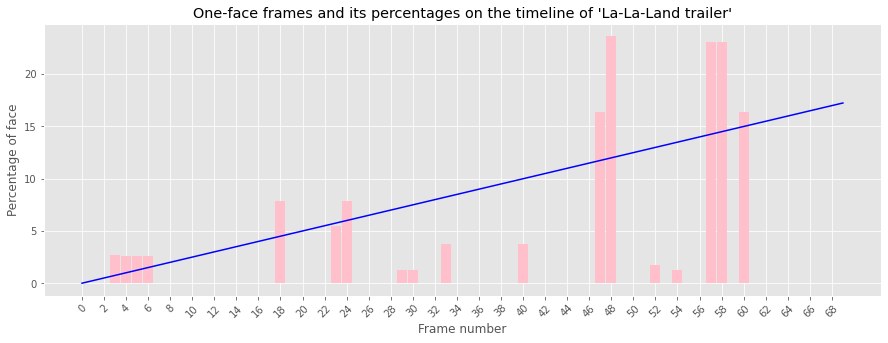

In [ ]:
visualize_hist_of_one_face_frames(dict_frame_num_perc, "pink", 70)

## **Шаг 9**: посчитаем, в какой трети находится лицо

In [ ]:
def greatest_third_part_area_count(face_coords, img_width, img_height=None):

    y_top_right, x_top_right,  y_bottom_left, x_bottom_left = face_coords    
    face_height = y_bottom_left - y_top_right
    x1_third, x2_third = img_width / 3, 2 * img_width / 3
    if x_top_right > x2_third and x_bottom_left < x1_third:
        return 2
    
    if x_top_right > x2_third > x_bottom_left:
        if x_top_right - x2_third >= x2_third - x_bottom_left:
            return 3
        else: 
            return 2
    
    if x_top_right > x1_third > x_bottom_left:
        
        if x_top_right - x1_third > x1_third - x_bottom_left:
            return 2
        else: 
            return 1
    
    if x_top_right > x2_third:
        return 3
    elif x_top_right < x1_third:
        return 1
    else:
        return 2

In [ ]:
def greatest_third_part_intersection(face_coords, img_width, img_height=None):

    y_top_right, x_top_right,  y_bottom_left, x_bottom_left = face_coords
    face_height = y_bottom_left - y_top_right
    x1_third, x2_third = img_width / 3, 2 * img_width / 3
    if x_top_right > x2_third and x_bottom_left < x1_third:
        return 2
    if x_top_right > x2_third:
        return "The face is located in the 3 third of the image"
    elif x_bottom_left < x1_third:
        return "The face is located in the 1 third of the image"
    else:
        return 2

In [ ]:
one_face['face_location'] = None
for index, row in one_face.iterrows():
    location= greatest_third_part_area_count(row[3],int(row['width']), int(row['height']))
    one_face.at[index,'face_location'] = location

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_face['face_location'] = None



In [ ]:
one_face.head()

,frame_num,num_of_faces,face_percentage,face_coordinates,width,height,face_location
1,024_frame.jpg,1,[7.9],"[255, 2064, 734, 1585]",1136,2558,3
2,060_frame.jpg,1,[16.4],"[214, 1747, 904, 1057]",1136,2558,3
5,030_frame.jpg,1,[1.3],"[144, 1834, 337, 1641]",1136,2558,3
22,029_frame.jpg,1,[1.3],"[144, 1877, 337, 1684]",1136,2558,3
23,003_frame.jpg,1,[2.7],"[239, 1687, 517, 1409]",1136,2558,3


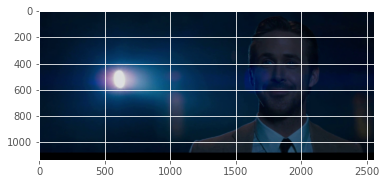

'The face is located in the 3 third of the image'

In [ ]:
image_show = cv2.imread('./frames/024_frame.jpg')
rgb = cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB)
image = face_recognition.load_image_file('./frames/024_frame.jpg')
image_copy = image.copy()
all_face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=2)

plt.imshow(rgb)
plt.show()

greatest_third_part_intersection(all_face_locations[0], 1136, 2558)